# drifters simulation in an extracted zone of llc4320
different sites under crossroads of swot trajectories (site)    
several release of drifters (dl)


In [1]:
import os, shutil

import math
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime

#import geopandas

import dask

%matplotlib inline
from matplotlib import pyplot as plt

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile, Variable
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.calval as ca

In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

processing = 1

if processing==0:
    cluster = LocalCluster()
elif processing==1:
    # parcels simulation
    cluster = PBSCluster(processes=4, cores=4, walltime='48:00:00')
#    w = cluster.scale(jobs=13)
    w = cluster.scale(jobs=1)
elif processing==2:
    # post processing
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.243:8787/status,
Dashboard: http://10.148.0.243:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.243:52119,Workers: 0
Dashboard: http://10.148.0.243:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## setup input parameters

In [3]:
# site directories
root_dir = '/home1/datawork/slgentil/parcels/'
site = 'med_south'           # 'californie', 'med_north', 'med_south'
dl = 8
speed = 5
season = 'winter'             # 'spring', 'summer', 'autumn', 'winter'

---
## setup simulation parameters

In [4]:
# simulation parameters
run_name = site+'_'+season
simu_name = 'dl'+str(dl)+'.speed'+str(speed)

T = 30. # length of the simulation [days]
dt_outputs = timedelta(hours=1.) # time between two storages of floats  [hour]
dt_step = timedelta(hours=1.) # time step [hour]
dt_window = timedelta(days=T) 

overwrite = False

bbox,lon_i,lat_i = ca.get_site_limits(site)
lonmin = bbox[0]
lonmax = bbox[1]
latmin = bbox[2]
latmax = bbox[3]

# Drifters released Back and forth
lon_i = lon_i + [lon_i[0]]
lat_i = lat_i + [lat_i[0]]
simu_name = simu_name+'.bf'

## Methods

Build tool to compute initial positions

In [5]:
def follow_path(lon, lat, dl, speed):
    """ Build a trajectory with dl (nautical miles) along the lon, lat paths
    
    Parameters
    ----------
    lon, lat: lists
        List of reference positions
    dl: float
        Distance between drifter release
    speed: float
        Speed of the ship in knots (nautical miles per hour)
    Returns
    -------
    lon_i, lat_i: lists
        Lists of release positions
    time: list
        Release deployment time in hours
    """
    hour2second = 3600.
    r = np.cos(np.pi/180.*np.mean(lat))
    time = [0.]
    for i in range(len(lon)-1):
        dlon = lon[i+1]-lon[i]
        dlat = lat[i+1]-lat[i]
        dl_segment = np.sqrt(dlon**2 * r**2 + dlat**2) # in deg
        ds = dl/60/dl_segment
        if i==0:
            lon_i, lat_i = [lon[0] - dlon * ds/2], [lat[0] - dlat * ds/2]
        s = 0
        while s<1:
            _lon = lon_i[-1] + dlon * ds
            _lat = lat_i[-1] + dlat * ds
            lon_i.append( _lon )
            lat_i.append( _lat )
            time.append( math.ceil(time[-1] + dl/speed) )
            s += ds
            #flag = ( (_lon-lon[i]) * (_lon-lon[i+1]) < 0 ) | ( (_lat-lat[i]) * (_lat-lat[i+1]) < 0 )
    return np.array(lon_i), np.array(lat_i), np.array(time) * timedelta(hours=1).total_seconds()


Get the geographical limits of the site 

---

## create tiles

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [6]:
# create run directory tree
dirs = pa.create_dir_tree(root_dir, run_name, overwrite=overwrite)

Not overwriting /home1/datawork/slgentil/parcels/med_south_winter
Not overwriting /home1/datawork/slgentil/parcels/med_south_winter/run
Not overwriting /home1/datawork/slgentil/parcels/med_south_winter/tiling
Not overwriting /home1/datawork/slgentil/parcels/med_south_winter/parquets
Not overwriting /home1/datawork/slgentil/parcels/med_south_winter/diagnostics


In [7]:
create_tiles = False
#create_tiles = overwrite

if create_tiles:
    # create tiling
    _ds = grd.reset_coords().persist()
    tl = pa.tiler(ds=_ds, factor=(1, 1), overlap=(250, 250), 
                  global_llc=False, lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)
    # store tiler
    tl.store(dirs["tiling"])
else:
    tl = pa.tiler(tile_dir=dirs["tiling"])

In [8]:
tl.create_tile_run_tree(dirs["run"], overwrite=overwrite)

Not overwriting /home1/datawork/slgentil/parcels/med_south_winter/run/data_000


---
## Compute initial positions¶

In [9]:
lon, lat, time = ca.follow_path(lon_i, lat_i, dl, speed)
print(time)

dl=8, speed=5, Number of drifter positions created = 11
[    0.  7200. 14400. 21600. 28800. 36000. 43200. 50400. 57600. 64800.
 72000.]


--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted within tile_store_llc)


In [10]:
def format_info(step, t_start, t_end):
    print('-------------------------------------------')
    print('step={}  /  start={}  /  end={}'
          .format(step,
                  t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                 )
         )

In [11]:
tile = 0
step = 0
restart = 0

# load, tile form llc.nc file (without face dimension)
ds_tile = pa.load_ds_tile(tl)[0]

t_start = ut.np64toDate(ds_tile['time'][0].values)
t_end = t_start + dt_window + dt_step
format_info(step, t_start, t_end)

# get new log filename for this run
log_file = pa.name_log_file(dirs['run'])

# clean up data for restart
tl.clean_up(dirs["run"], restart)

local_numbers = {tile: 0 for tile in range(tl.N_tiles)}
max_ids = {tile: None for tile in range(tl.N_tiles)}

#for tile in range(tl.N_tiles):
tile = 0
step_out = \
        pa.step_window(tile, step, 
                       t_start, t_end,
                       dt_window, dt_step, dt_outputs, 
                       tl,
                       ds_tile=ds_tile,  
                       lon=lon, lat=lat, time=time, 
                       parcels_remove_on_land=True,
                       pclass="extended",
                       id_max=max_ids[tile],
                      )

max_ids = {tile: int(step_out[1])}
local_numbers = {tile: int(step_out[0])}
log = dict(
           local_numbers=local_numbers,
           max_ids=max_ids,
          )

# store log
pa.store_log(log_file, step, log)

print('Total number of particles start/end= {}/{}'
      .format(lon.size,local_numbers[0])
     )
    

-------------------------------------------
step=0  /  start=2012-02-15:00  /  end=2012-03-16:01


INFO: Compiled ArrayParticle_extendedRemoveOnLand ==> /dev/shm/pbs.6859776.datarmor0/parcels-16088/lib06327b4d68860f734984d224bbb4826a_0.so
INFO: Compiled ArrayParticle_extendedExtended_SampleAdvectionRK4 ==> /dev/shm/pbs.6859776.datarmor0/parcels-16088/lib75653af6f64b52a81096bc97fa3ee568_0.so
/home1/datahome/slgentil/conda-env/equinox/lib/python3.8/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Total number of particles start/end= 11/0


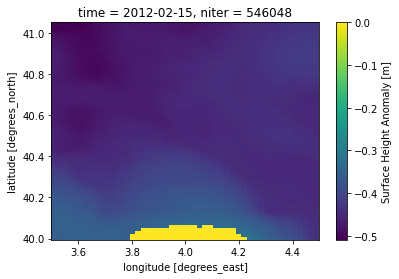

In [12]:
ds_tile.Eta.isel(time=0).plot.pcolormesh(x='XC',y='YC')

Change name of the floats netcdf file according to the simulation name. The goal is to keep the same llc.nc file for several simulations, with different float releases

In [13]:
run_dir = dirs['run']
f = os.path.join(run_dir, "data_000/floats_000_000.nc")
if os.path.isfile(f):
    f_new = f.replace('000_000',simu_name)
    os.rename(f, f_new)

Plot trajectories

In [14]:
df = pa.load_nc(dirs["run"], index='time', step_tile=simu_name, persist=True).compute()
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2012-02-15 00:00:00,0,40.335371,4.078457,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2012-02-15 01:00:00,0,40.323309,4.094138,0.0,0.000004,-0.000003,-0.417760,13.231480,37.502831
2012-02-15 02:00:00,0,40.311032,4.109312,0.0,0.000004,-0.000004,-0.411080,13.231030,37.502945
2012-02-15 03:00:00,0,40.298351,4.124218,0.0,0.000004,-0.000003,-0.407704,13.298498,37.500473
2012-02-15 04:00:00,0,40.286419,4.139046,0.0,0.000004,-0.000003,-0.420078,13.239005,37.504765


NaT


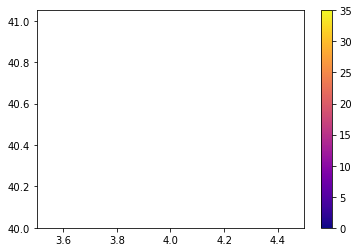

In [15]:
# positions after all the drifters are released

# Compute the first time where all the drifters are released
nb_flt = df['trajectory'].unique().size      # Compute number of released drifters
_df = pd.Index(df.index).value_counts()      # get number of rows per time
_df = _df[_df == nb_flt]                            # Keep lines with nb_flt number of rows
t_released = _df.index.min()                        # Keep  the min date
print(t_released)

_df = df.loc[t_released]
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.xlim(lonmin,lonmax)
plt.ylim(latmin,latmax)
plt.colorbar()

In [16]:
df.loc[t_start]

trajectory              0.000000
lat                    40.335371
lon                     4.078457
z                       0.000000
zonal_velocity          0.000000
meridional_velocity     0.000000
sea_level               0.000000
temperature             0.000000
salinity                0.000000
Name: 2012-02-15 00:00:00, dtype: float64

In [17]:
# positions at the end of the simulation
try:
    _df = df.loc[t_end]
    plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
                vmin=0, vmax=35, cmap='plasma')
    plt.xlim(lonmin,lonmax)
    plt.ylim(latmin,latmax)
    plt.colorbar()
except:
    print('No more drifters at the end of the simulation')

No more drifters at the end of the simulation


plot trajectories of the simulation

## Close cluster

In [18]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
